# Hadamard with Perforners
**Raphaël Adda & Sheldon Allen**

The performer implementation is inspired from the work of Teddy Koker, available here https://teddykoker.com/2020/11/performers/.
In this notebook, we will run some experiments to assess the efficiency of using Hadamard-Rademacher orthogonal projection instead of Gaussian orthogonal projection in the Performers of Choromanski et al., 2020 (Rethinking Attention with Performers).

## 1 - Implementation of Performers

The implementation of the regular Attention and FAVOR+ mechanisms is in the file numpy_performers.py.
Indeed, we use the Teddy Koker implementation of performers using numpy in order to run some fast tests to assess the efficiency of performers with and without Hadamard Orthogonal projection



In [18]:
from numpy_performers import *
import numpy as np
import time

The function Orthogonal_Hadamard(m,d,k) in the file numpy_performers allows to generate a Hadamard-Rademacher orthogonal projection matrix, using the FWHT function (Fast Walsh Hadamard Transform algorithm) of the file Fast_Walsh_Hadamard_Transform.py: $\\$
it is an algorithm wich allows to perform a product of a  Hadamard matrix  $H_{m}$ with a vector $v \in \mathcal{R}^{2^m}$ in $O(nlog(n))$ with $n = 2^m$.

## 2 - Some experimentations

## 2.1- MSE of the approximation of attention in function of the number of features

The Hadamard experimentation begins here

In [27]:
# sequence length and hidden dim
l = 1024
d = 16

num_samples = 15

# random feature sizes to try
ms = np.arange(d, 600, 16)

In [14]:
sincos_hadamard = []
positive_hadamard = []
hadam = []

if isPowerOfTwo(d):   
  np.random.seed(0)
  for m in ms:
      sincos_hadamard.append([])
      positive_hadamard.append([])
      hadam.append([])
      for _ in range(num_samples):
        q = 1.5 * np.random.randn(l, d) 
        k = 1.5 * np.random.randn(l, d) 
        v = 1.5 * np.random.randn(l, d)



        att_true = att(q, k, v)

        random_feats = Orthogonal_Hadamard(m, d)
        sincos_hadamard[-1].append(mse(att_true, sincos_att_hat(q, k, v, random_feats,m)))
        positive_hadamard[-1].append(mse(att_true, positive_att_hat(q, k, v, random_feats,m)))

      hadam[-1].append(mse(att_true, positive_att_hat(q, k, v, random_feats,m)))
  sincos_hadamard = np.array(sincos_hadamard)
  positive_hadamard = np.array(positive_hadamard)

else:
  d_proj = next_larger_power_of_two(d)
  np.random.seed(0)
  for m in ms:
    sincos_hadamard.append([])
    positive_hadamard.append([])
    hadam.append([])
    for _ in range(num_samples):
        q = np.hstack([np.random.randn(l, d) * 1.5,np.zeros((l,d_proj-d))])
        k = np.hstack([np.random.randn(l, d) * 1.5,np.zeros((l,d_proj-d))])
        v = np.hstack([np.random.randn(l, d) * 1.5,np.zeros((l,d_proj-d))])

        att_true = att(q, k, v).T[0:d].T

        random_feats = Orthogonal_Hadamard(m, d_proj)
        sincos_hadamard[-1].append(mse(att_true, sincos_att_hat(q, k, v, random_feats).T[0:d].T))
        positive_hadamard[-1].append(mse(att_true, positive_att_hat(q, k, v, random_feats).T[0:d].T))

    hadam[-1].append(mse(att_true, positive_att_hat(q, k, v, random_feats).T[0:d].T))

  sincos_hadamard = np.array(sincos_hadamard)
  positive_hadamard = np.array(positive_hadamard)

In [21]:
positive_iid = []
positive_gauss = []

np.random.seed(0)
for m in ms:
    positive_iid.append([])
    positive_gauss.append([])

    for _ in range(num_samples):
        q = 1.5 * np.random.randn(l, d) 
        k = 1.5 * np.random.randn(l, d) 
        v = 1.5 * np.random.randn(l, d)

        att_true = att(q, k, v)

        ortho_feats = orthogonal_gaussian(m, d)
        iid_feats = iid_gaussian(m, d)
        positive_gauss[-1].append(mse(att_true, positive_att_hat(q, k, v, ortho_feats,m)))
        positive_iid[-1].append(mse(att_true, positive_att_hat(q, k, v, iid_feats,m)))

positive_iid = np.array(positive_iid)
positive_gauss = np.array(positive_gauss)

In [16]:
sin_cos_iid = []
sin_cos_gauss = []

np.random.seed(0)
for m in ms:
    sin_cos_iid.append([])
    sin_cos_gauss.append([])

    for _ in range(num_samples):
        q = 1.5 * np.random.randn(l, d) 
        k = 1.5 * np.random.randn(l, d) 
        v = 1.5 * np.random.randn(l, d)


        att_true = att(q, k, v)

        ortho_feats = orthogonal_gaussian(m, d)
        iid_feats = iid_gaussian(m, d)
        sin_cos_gauss[-1].append(mse(att_true, sincos_att_hat(q, k, v, ortho_feats,m)))
        sin_cos_iid[-1].append(mse(att_true, sincos_att_hat(q, k, v, iid_feats,m)))

sin_cos_iid = np.array(sin_cos_iid)
sin_cos_gauss = np.array(sin_cos_gauss)

In [7]:
def plot_line(x, y,label,color= None):
    mean = y.mean(axis=1)
    std = y.std(axis=1)
    plt.plot(x, mean, label=label,color = color)
    plt.fill_between(x, mean + std, mean - std, alpha=0.1)

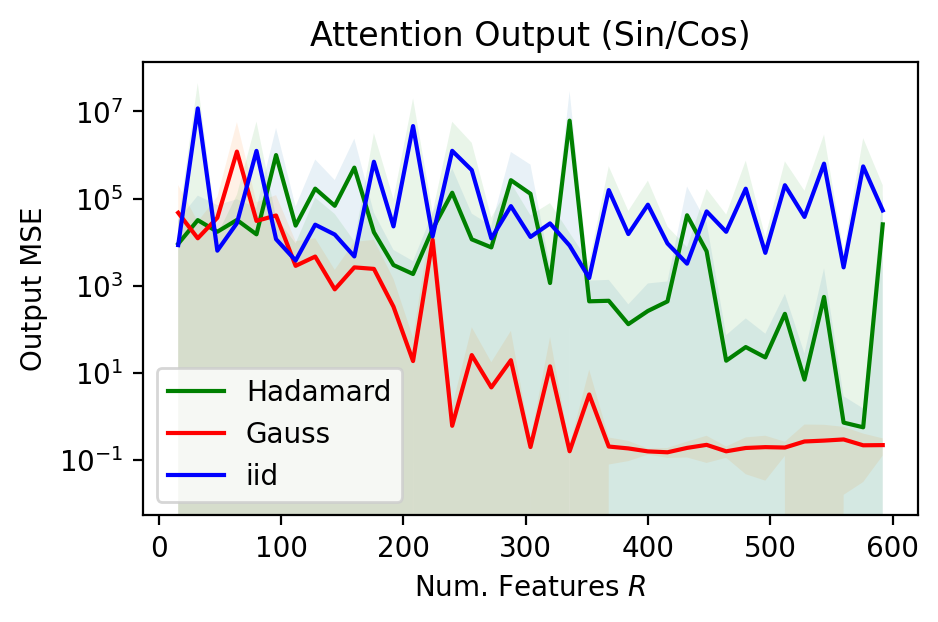

In [17]:
plt.figure(figsize=(5, 3), dpi=200)
plot_line(ms, sincos_hadamard, "Hadamard",color='green')
plot_line(ms, sin_cos_gauss, "Gauss",color='red')
plot_line(ms, sin_cos_iid, "iid",color='blue')
plt.yscale("log")
# plt.ylim(1e-2, 1e8)
plt.ylabel("Output MSE")
plt.xlabel("Num. Features $R$")
plt.title("Attention Output (Sin/Cos)")
plt.legend()
plt.savefig("gauss_vs_hadamard_vs_iid_trig.pdf", bbox_inches="tight")

In [20]:
positive_gauss

array([], shape=(37, 0), dtype=float64)

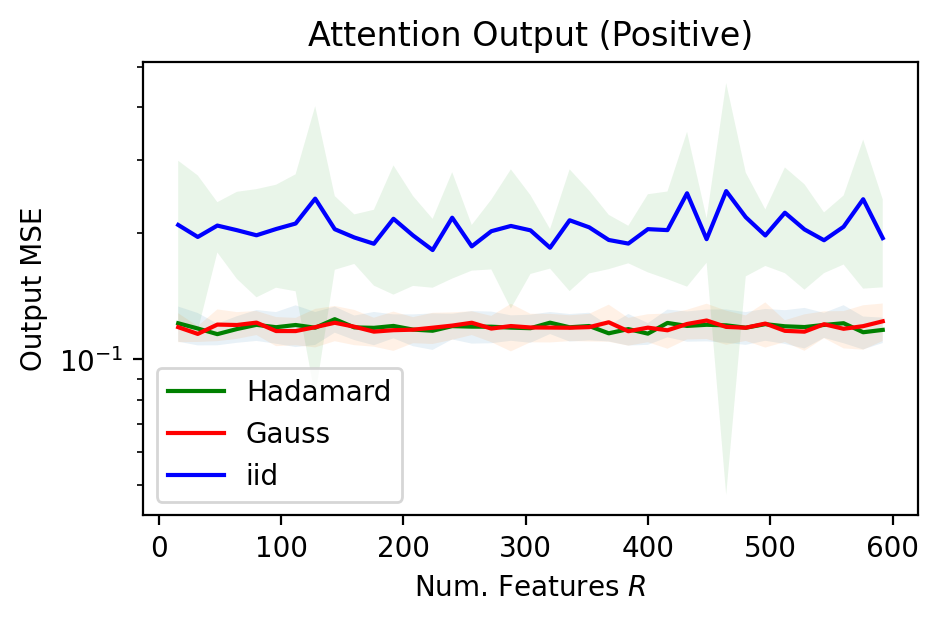

In [23]:
plt.figure(figsize=(5, 3), dpi=200)
plot_line(ms, positive_hadamard, "Hadamard",color='green')
plot_line(ms, positive_gauss, "Gauss",color='red')
plot_line(ms, positive_iid, "iid",color='blue')
plt.yscale("log")
plt.ylabel("Output MSE")
plt.xlabel("Num. Features $R$")
plt.title("Attention Output (Positive)")
plt.legend()
plt.savefig("gauss_vs_hadamard_vs_iid_positive.pdf", bbox_inches="tight")

## 2.2 Time computation comparaison in function of the input sequence length

### 2.2.1 For sin/cos attention

In [88]:
L = np.arange(1024,16192,200)
d = 16

num_samples = 15

# random feature size
m = 300

In [89]:
sin_cos_gauss_time = []
np.random.seed(0)
for l in L:
        q = 1.5 * np.random.randn(l, d) 
        k = 1.5 * np.random.randn(l, d) 
        v = 1.5 * np.random.randn(l, d)
        time_1 = time.time()
        ortho_feats = orthogonal_gaussian(m, d)
        sincos_att_hat(q, k, v, ortho_feats,m)
        sin_cos_gauss_time.append(time.time() - time_1)
sin_cos_gauss_time = np.array(sin_cos_gauss_time)

In [90]:
sin_cos_iid_time = []
np.random.seed(0)
for l in L:
        q = 1.5 * np.random.randn(l, d) 
        k = 1.5 * np.random.randn(l, d) 
        v = 1.5 * np.random.randn(l, d)
        time_1 = time.time()
        iid_feats = iid_gaussian(m, d)
        sincos_att_hat(q, k, v, iid_feats,m)
        sin_cos_iid_time.append(time.time() - time_1)
sin_cos_iid_time = np.array(sin_cos_iid_time)

In [91]:
sin_cos_hadamard_time = []
np.random.seed(0)
if isPowerOfTwo(d):
    for l in L:
            q = 1.5 * np.random.randn(l, d) 
            k = 1.5 * np.random.randn(l, d) 
            v = 1.5 * np.random.randn(l, d)
            time_1 = time.time()
            random_feats = Orthogonal_Hadamard(m, d)
            sincos_att_hat(q, k, v, random_feats,m)
            sin_cos_hadamard_time.append(time.time() - time_1)
    sin_cos_hadamard_time = np.array(sin_cos_hadamard_time)
else:
    d_proj = next_larger_power_of_two(d)
    for l in L:
        q = np.hstack([np.random.randn(l, d) * 1.5,np.zeros((l,d_proj-d))])
        k = np.hstack([np.random.randn(l, d) * 1.5,np.zeros((l,d_proj-d))])
        v = np.hstack([np.random.randn(l, d) * 1.5,np.zeros((l,d_proj-d))])

        time_1 = time.time()
        random_feats = Orthogonal_Hadamard(m, d_proj)
        sincos_att_hat(q, k, v, random_feats).T[0:d].T
        sin_cos_hadamard_time.append(time.time() - time_1)
    sin_cos_hadamard_time = np.array(sin_cos_hadamard_time)

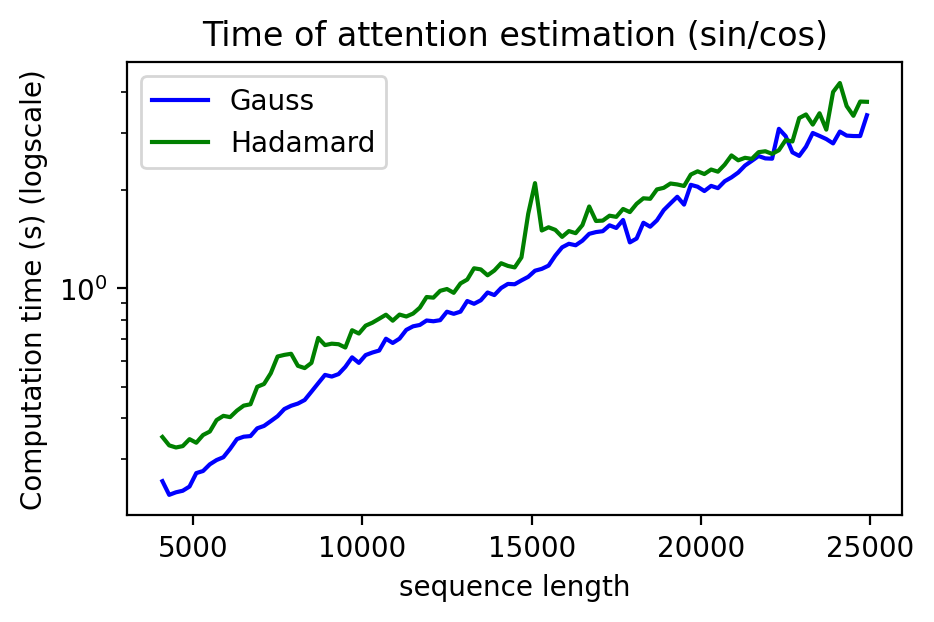

In [103]:
plt.figure(figsize=(5, 3), dpi=200)
plt.plot(L, sin_cos_gauss_time, label="Gauss",color = "blue")
plt.plot(L, sin_cos_hadamard_time, label="Hadamard",color = "green")
plt.yscale("log")
plt.ylabel("Computation time (s) (logscale)")
plt.xlabel("sequence length")
plt.title("Time of attention estimation (sin/cos)")
plt.legend()
plt.show()

### 2.2.2 For positive attention

In [93]:
L = np.arange(4096,25000,200) #input sequence lengths lists
d = 16 # hidden dimension
# random feature size
m = 300

In [94]:
positive_gauss_time = []
np.random.seed(0)
for l in L:
        q = 1.5 * np.random.randn(l, d) 
        k = 1.5 * np.random.randn(l, d) 
        v = 1.5 * np.random.randn(l, d)
        time_1 = time.time()
        ortho_feats = orthogonal_gaussian(m, d)
        positive_att_hat(q, k, v, ortho_feats,m)
        positive_gauss_time.append(time.time() - time_1)
positive_gauss_time = np.array(positive_gauss_time)

In [95]:
positive_hadamard_time = []
np.random.seed(0)
if isPowerOfTwo(d):
    for l in L:
            q = 1.5 * np.random.randn(l, d) 
            k = 1.5 * np.random.randn(l, d) 
            v = 1.5 * np.random.randn(l, d)
            time_1 = time.time()
            random_feats = Orthogonal_Hadamard(m, d)
            positive_att_hat(q, k, v, random_feats,m)
            positive_hadamard_time.append(time.time() - time_1)
    positive_hadamard_time = np.array(positive_hadamard_time)
else:
    d_proj = next_larger_power_of_two(d)
    for l in L:
        q = np.hstack([np.random.randn(l, d) * 1.5,np.zeros((l,d_proj-d))])
        k = np.hstack([np.random.randn(l, d) * 1.5,np.zeros((l,d_proj-d))])
        v = np.hstack([np.random.randn(l, d) * 1.5,np.zeros((l,d_proj-d))])

        time_1 = time.time()
        random_feats = Orthogonal_Hadamard(m, d_proj)
        positive_att_hat(q, k, v, random_feats).T[0:d].T
        positive_hadamard_time.append(time.time() - time_1)
    positive_hadamard_time = np.array(positive_hadamard_time)

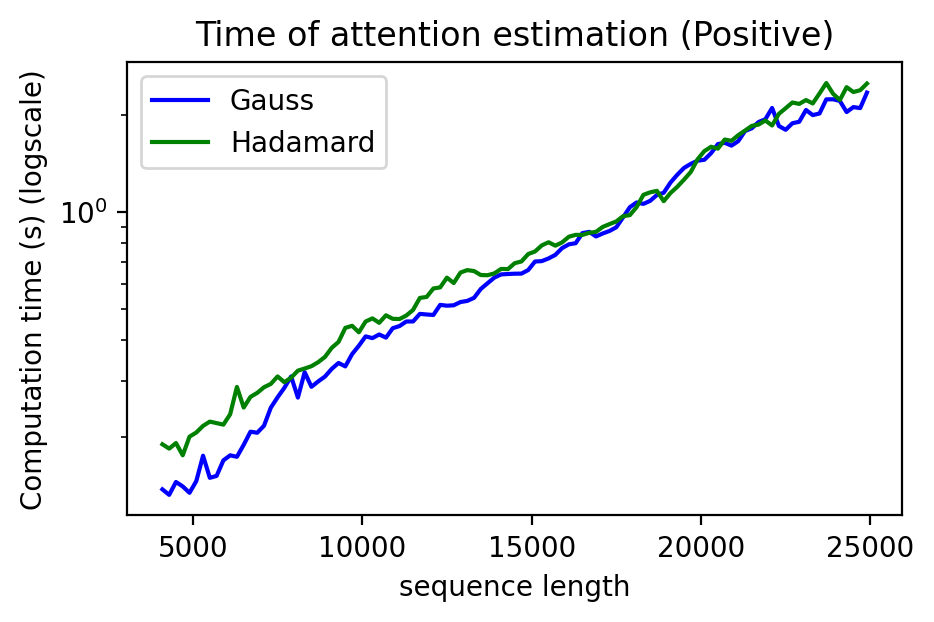

In [104]:
plt.figure(figsize=(5, 3), dpi=200)
plt.plot(L, positive_gauss_time, label="Gauss",color = "blue")
plt.plot(L, positive_hadamard_time, label="Hadamard",color = "green")
plt.yscale("log")
plt.ylabel("Computation time (s) (logscale)")
plt.xlabel("sequence length")
plt.title("Time of attention estimation (Positive)")
plt.legend()
plt.show()